## Import

In [1]:
import pyVHR
from pyVHR.analysis.pipeline import Pipeline

2023-03-08 15:16:32.455018: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [73]:
from glob import glob
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.signal import find_peaks
import heartpy as hp
from biosppy.signals import tools, ppg

## Prepare the video

In [3]:
subject_name = 'adin6'
# the img_dir_path is 'dataset/(subect_name)/rgb'
img_dir_path = os.path.join('dataset', subject_name, 'rgb')
img_frame_individual_path = glob(os.path.join(img_dir_path, "*.jpg"))
img_frame_individual_path.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
print(f"Total number of frames: {len(img_frame_individual_path)}")

Total number of frames: 1800


In [ ]:
# convert all image in the img_Frame_individual_path from 1080 to 720
for image in img_frame_individual_path:
    img = cv2.imread(image)
    img = cv2.resize(img, (1280, 720))
    cv2.imwrite(image, img)

In [4]:
FPS = 30
size = (1280, 720)
save_path = os.path.join('dataset', subject_name, (subject_name + '.avi'))

In [ ]:
out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'MJPG'), FPS, size)

# read every image and write to video
for img in img_frame_individual_path:
    frame = cv2.imread(img)
    out.write(frame)

# release the video
out.release()

## Get the rPPG signal

In [5]:
from inspect import getmembers, isfunction
av_meths = getmembers(pyVHR.BVP.methods, isfunction)
available_methods = [am[0] for am in av_meths]
print(f"Available methods: {available_methods}")

Available methods: ['cpu_CHROM', 'cpu_GREEN', 'cpu_ICA', 'cpu_LGI', 'cpu_OMIT', 'cpu_PBV', 'cpu_PCA', 'cpu_POS', 'cpu_SSR', 'cupy_CHROM', 'cupy_POS', 'jadeR', 'torch_CHROM']


In [14]:
w_size = 60
method = 'cpu_POS'
pipe = Pipeline()
forehead_mediapipe_landmark = [69, 108, 151, 337, 299, 333, 334, 296, 136, 9, 107, 66, 8, 285, 295, 282, 55, 65, 52]
cheek_mediapipe_landmark = [277, 349, 450, 449, 448, 261, 265, 372, 264, 447, 345, 229, 348, 347, 346, 345, 447, 264, 386, 352, 280, 425, 266, 423, 426, 427, 416, 433]

In [19]:
bvps_win_fh, timesES_fh, bpmES_fh = pipe.run_on_video(
    videoFileName=save_path,
    method=method,
    winsize=w_size,
    cuda=True,
    verb=False,
    ldmks_list=forehead_mediapipe_landmark,
    roi_approach='patches',
    estimate='median',
)

bvps_win_ch, timesES_ch, bpmES_ch = pipe.run_on_video(
    videoFileName=save_path,
    method=method,
    winsize=w_size,
    cuda=True,
    verb=False,
    ldmks_list=cheek_mediapipe_landmark,
    roi_approach='patches',
    estimate='median',
)

# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti
# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti


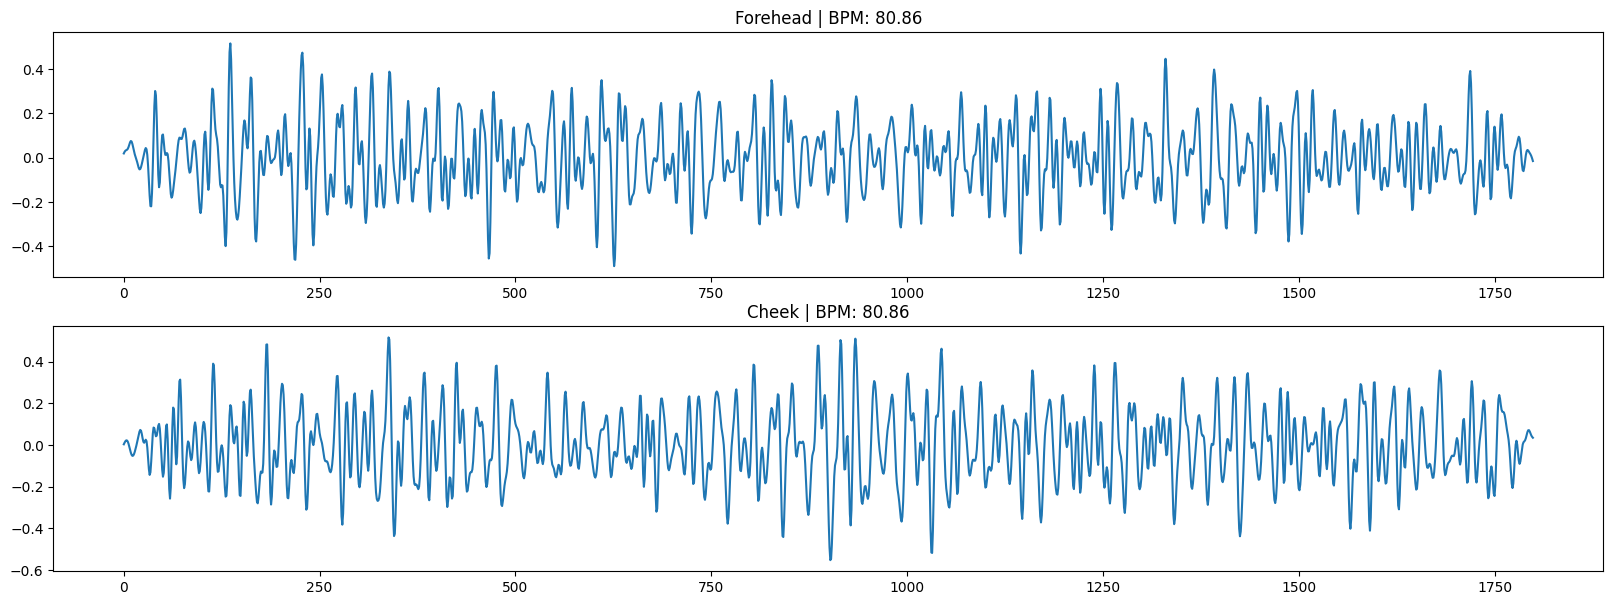

In [32]:
bvps_forehead = bvps_win_fh[0][0]
bvps_cheek = bvps_win_ch[0][0]

# compare between forehead and cheek in subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
ax1.plot(bvps_forehead)
ax1.set_title(f"Forehead | BPM: {bpmES_fh[0]:.2f}")
ax2.plot(bvps_cheek)
ax2.set_title(f"Cheek | BPM: {bpmES_ch[0]:.2f}")
plt.show()


## Obtain the Spectrum using FFT

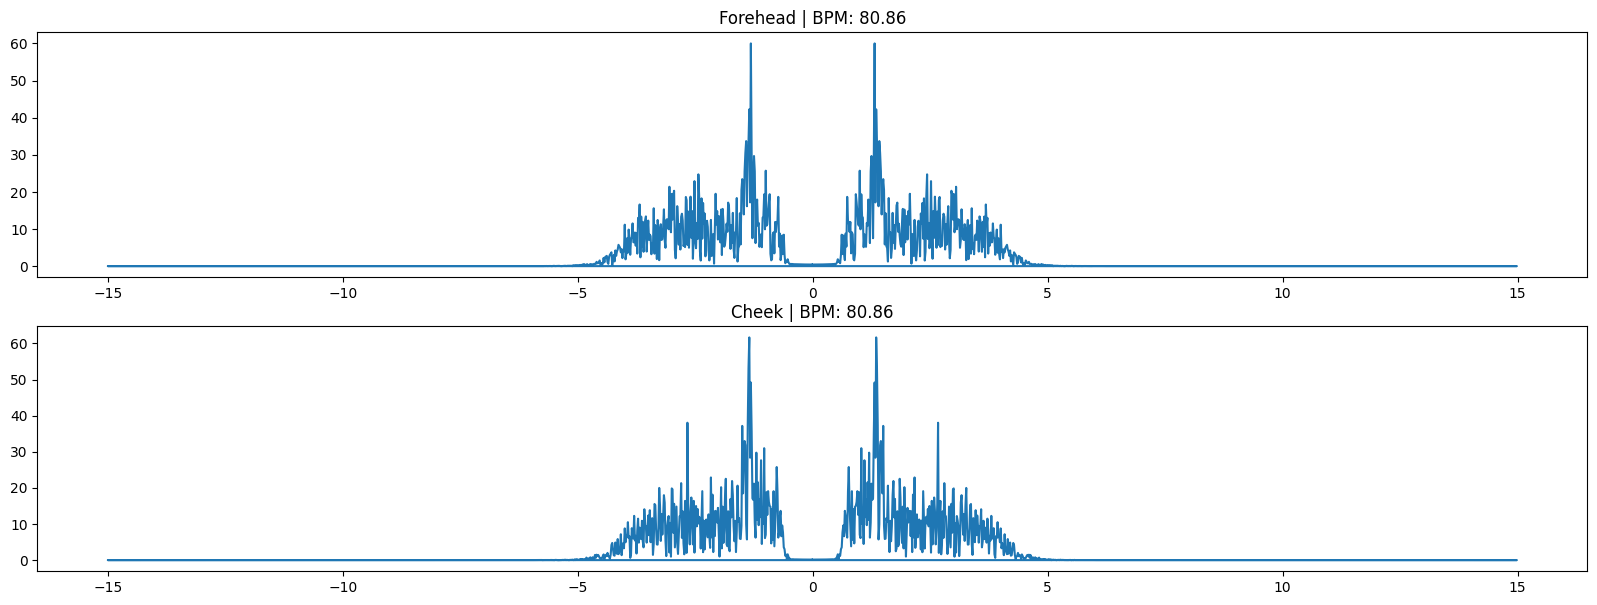

In [34]:
FS = 30
fft_bvps_forehead = np.fft.fft(bvps_forehead)
fft_bvps_cheek = np.fft.fft(bvps_cheek)
freqs_fh = np.fft.fftfreq(len(fft_bvps_forehead), 1/FS)
freqs_ch = np.fft.fftfreq(len(fft_bvps_cheek), 1/FS)

# plot the magnitude of fft using subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 7))
ax1.plot(freqs_fh, np.abs(fft_bvps_forehead))
ax1.set_title(f"Forehead | BPM: {bpmES_fh[0]:.2f}")
ax2.plot(freqs_ch, np.abs(fft_bvps_cheek))
ax2.set_title(f"Cheek | BPM: {bpmES_ch[0]:.2f}")
plt.show()


In [45]:
# get the highest energy
max_energy_fh = np.argmax(np.abs(fft_bvps_forehead))
max_energy_ch = np.argmax(np.abs(fft_bvps_cheek))
print(f"Forehead: {freqs_fh[max_energy_fh]:.2f} Hz")
print(f"Cheek: {freqs_ch[max_energy_ch]:.2f} Hz")

Forehead: 1.32 Hz
Cheek: 1.35 Hz


In [46]:
phase_forehead = np.angle(fft_bvps_forehead[max_energy_fh])
phase_cheek = np.angle(fft_bvps_cheek[max_energy_ch])
# phase difference is the difference between the phase of the forehead and the phase of the cheek
phase_difference = phase_forehead - phase_cheek
print(f"Forehead phase: {phase_forehead:.2f} rad")
print(f"Cheek phase: {phase_cheek:.2f} rad")
print(f"Phase difference: {phase_difference:.2f} rad")

Forehead phase: -0.10 rad
Cheek phase: -0.77 rad
Phase difference: 0.67 rad


$ PTT = TimeDelay = \frac{PhaseDiff}{2 \pi \times f} $

In [49]:
PTT = phase_difference / (2 * np.pi * freqs_fh[max_energy_fh])
print(f"PTT: {PTT:.2f} s")
# in ms
PTT_inms = PTT * 1000
print(f"PTT: {PTT_inms:.2f} ms")

PTT: 0.08 s
PTT: 81.52 ms


## Re-run the rPPG to get the signal for HR and HRV

In [50]:
bvps_win_main, timesES_main, bpmES_main = pipe.run_on_video(
    videoFileName=save_path,
    method=method,
    winsize=w_size,
    cuda=True,
    verb=False,
)

# CUDA devices:  1
# device number  0 :  NVIDIA GeForce RTX 2080 Ti


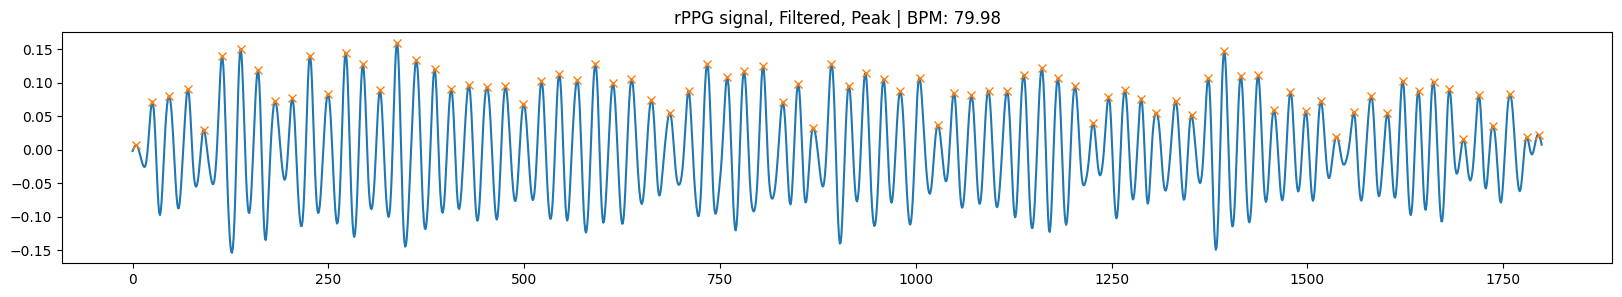

In [67]:
rPPG_signal_main = bvps_win_main[0][0]
# filter the signal using bandpass
rPPG_signal_main_filtered = hp.filter_signal(
    rPPG_signal_main,
    cutoff = [0.5, 2],
    sample_rate = FS,
    filtertype = 'bandpass',
)
rPPG_signal_main_peak, _ = find_peaks(rPPG_signal_main_filtered)

plt.figure(figsize=(20, 3))
plt.title("rPPG signal, Filtered, Peak | BPM: {:.2f}".format(bpmES_main[0]))
plt.plot(rPPG_signal_main_filtered)
plt.plot(rPPG_signal_main_peak, rPPG_signal_main_filtered[rPPG_signal_main_peak], "x")

## Count SDNN, LF, HF, and LF/HF

In [72]:
# count the interbeats interval
ibis = np.diff(rPPG_signal_main_peak) / FS
print(f"Length of IBI: {len(ibis)}")
# calculate mean Interval
mean_interval = np.mean(ibis)
# calculate SDNN
sdnn = np.std(ibis, ddof=1)
print(f"Mean Interval: {mean_interval:.2f} s")
print(f"SDNN: {sdnn:.2f} s")

Length of IBI: 82
Mean Interval: 0.73 s
SDNN: 0.06 s


In [82]:
# resample IBIs to a uniform scale
t = np.arange(0, ibis.sum(), 1/FS)
ibi_interp = np.interp(t, np.cumsum(ibis), ibis)
print(f"IBI interpolation length: {len(ibi_interp)}")
# compute the power spectrum of the IBI using Lomb-Scargle Periodogram
freqs, power = sig.welch(ibi_interp, fs=FS, nperseg=1024)
# Define frequency bands for LF and HF
lf_band = (0.04, 0.15)  # in Hz
hf_band = (0.15, 0.4)  # in Hz
lf_power = np.trapz(power[(freqs >= lf_band[0]) & (freqs <= lf_band[1])])
hf_power = np.trapz(power[(freqs >= hf_band[0]) & (freqs <= hf_band[1])])
print(f"LF power: {lf_power:.2f}")
print(f"HF power: {hf_power:.2f}")

# compute the LF/HF ratio
lf_hf_ratio = lf_power / hf_power
print(f"LF/HF ratio: {lf_hf_ratio:.2f}")


IBI interpolation length: 1791
LF power: 0.01
HF power: 0.02
LF/HF ratio: 0.36


## List all 7 features for f-Net

In [87]:
print(f"1. Heart Rate: {bpmES_main[0]:.2f} bpm")
print(f"2. SDNN: {sdnn:.2f} s")
print(f"3. LF power: {lf_power:.2f}")
print(f"4. HF power: {hf_power:.2f}")
print(f"5. LF/HF ratio: {lf_hf_ratio:.2f}")
print(f"6. PTT: {PTT_inms:.2f} ms")
print(f"7. Body Mass Index: FROM THE CSV DATASET OR YOU CAN REMOVE THIS")

1. Heart Rate: 79.98 bpm
2. SDNN: 0.06 s
3. LF power: 0.01
4. HF power: 0.02
5. LF/HF ratio: 0.36
6. PTT: 81.52 ms
7. Body Mass Index: FROM THE CSV DATASET OR YOU CAN REMOVE THIS
